<a href="https://colab.research.google.com/github/Pranada6467/PCAP-project/blob/main/GPUvsCPU_Pcap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install dependencies
!apt-get update -qq && apt-get install -y -qq build-essential cmake git libgtk2.0-dev pkg-config libavcodec-dev libavformat-dev libswscale-dev libtbb2 libtbb-dev libjpeg-dev libpng-dev libtiff-dev libdc1394-22-dev
!pip install numpy -q

# Remove conflicting OpenCV versions
!pip uninstall opencv-python opencv-contrib-python -y -q
!rm -rf /usr/lib/python3.11/dist-packages/cv2

# Clone OpenCV and contrib
!git clone https://github.com/opencv/opencv.git -q
!git clone https://github.com/opencv/opencv_contrib.git -q

# Configure and build OpenCV with CUDA
!cd opencv && mkdir build && cd build
!cd opencv/build && cmake \
  -D CMAKE_BUILD_TYPE=RELEASE \
  -D CMAKE_INSTALL_PREFIX=/usr/local \
  -D WITH_CUDA=ON \
  -D WITH_CUDNN=ON \
  -D OPENCV_DNN_CUDA=ON \
  -D CUDA_ARCH_BIN=7.5 \
  -D CUDA_TOOLKIT_ROOT_DIR=/usr/local/cuda \
  -D OPENCV_EXTRA_MODULES_PATH=/content/opencv_contrib/modules \
  -D BUILD_EXAMPLES=OFF \
  -D BUILD_opencv_python3=ON \
  -D PYTHON3_EXECUTABLE=$(which python3) \
  -D PYTHON3_INCLUDE_DIR=$(python3 -c "import sysconfig; print(sysconfig.get_path('include'))") \
  -D PYTHON3_PACKAGES_PATH=$(python3 -c "import site; print(site.getsitepackages()[0])") \
  .. > cmake_output.txt 2>&1  # Redirect output to file for speed
!cd opencv/build && make -j2  # Use 2 cores to avoid memory issues
!cd opencv/build && make install

# Set library path
!export LD_LIBRARY_PATH=/usr/local/cuda/lib64:/usr/local/lib:$LD_LIBRARY_PATH

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
E: Unable to locate package libdc1394-22-dev
[  0%] Built target opencv_dnn_plugins
[  0%] Built target opencv_highgui_plugins
[  0%] Built target opencv_videoio_plugins
[  0%] Building C object 3rdparty/ippiw/CMakeFiles/ippiw.dir/src/iw_core.c.o
[  0%] Building C object 3rdparty/ittnotify/CMakeFiles/ittnotify.dir/src/ittnotify/ittnotify_static.c.o
[  0%] Building C object 3rdparty/ippiw/CMakeFiles/ippiw.dir/src/iw_image.c.o
[  0%] Building C object 3rdparty/ippiw/CMakeFiles/ippiw.dir/src/iw_image_color_convert_all.c.o
[  0%] Building C object 3rdparty/ippiw/CMakeFiles/ippiw.dir/src/iw_image_color_convert_rgbs.c.o
[  0%] Building C object 3rdparty/ippiw/CMakeFiles/ippiw.dir/src/iw_image_filter_bilateral.c.o
[  0%] Building C object 3rdparty/ippiw/CMakeFiles/ippiw.dir/src/iw_image_filter_box.c.o
[  0%

In [2]:
import sys
sys.path.insert(0, '/usr/local/lib/python3.11/dist-packages')
import cv2
print("OpenCV version:", cv2.__version__)
print("CUDA devices:", cv2.cuda.getCudaEnabledDeviceCount())
if cv2.cuda.getCudaEnabledDeviceCount() > 0:
    print("CUDA device info:")
    cv2.cuda.printCudaDeviceInfo(0)
else:
    raise RuntimeError("CUDA not enabled! Check build logs.")

OpenCV version: 4.12.0-dev
CUDA devices: 1
CUDA device info:


 Basic CPU vs. GPU Pipeline Demonstration

CPU GaussianBlur: 14.20 ms
GPU GaussianBlur: 1.12 ms
Speedup: 12.73x


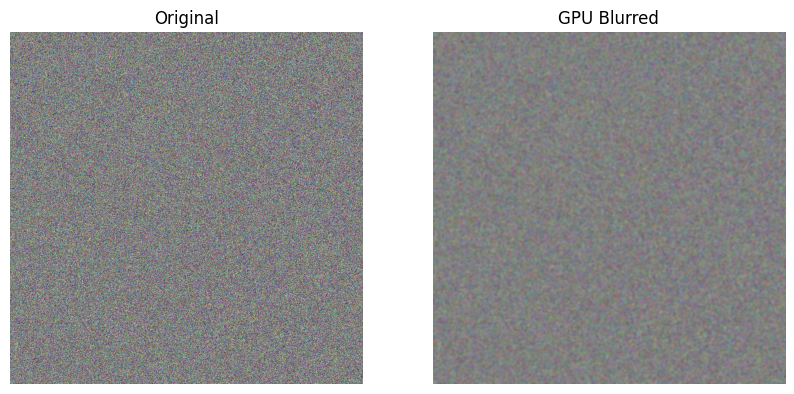

In [4]:
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt

# 1. Create a random image (or load from disk)
img = np.random.randint(0, 256, (1024, 1024, 3), dtype=np.uint8)

# 2. CPU Gaussian Blur
start_cpu = time.time()
cpu_blurred = cv2.GaussianBlur(img, (15, 15), 0)
end_cpu = time.time()
cpu_time = end_cpu - start_cpu

# 3. GPU Gaussian Blur
gpu_img = cv2.cuda_GpuMat()
gpu_img.upload(img)

gauss_filter = cv2.cuda.createGaussianFilter(
    srcType=gpu_img.type(),
    dstType=gpu_img.type(),
    ksize=(15, 15),
    sigma1=0
)

start_gpu = time.time()
gpu_blurred_mat = gauss_filter.apply(gpu_img)
end_gpu = time.time()
gpu_time = end_gpu - start_gpu

# Convert from GPU to CPU memory
gpu_blurred = gpu_blurred_mat.download()

# 4. Print timing results
print(f"CPU GaussianBlur: {cpu_time*1000:.2f} ms")
print(f"GPU GaussianBlur: {gpu_time*1000:.2f} ms")
if gpu_time != 0:
    print(f"Speedup: {cpu_time/gpu_time:.2f}x")

# 5. Display results side by side
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1,2,2)
plt.title("GPU Blurred")
plt.imshow(cv2.cvtColor(gpu_blurred, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()


Eg1.Edge Detection

Sobel - CPU: 3.23 ms, GPU: 0.56 ms, Speedup: 5.81x


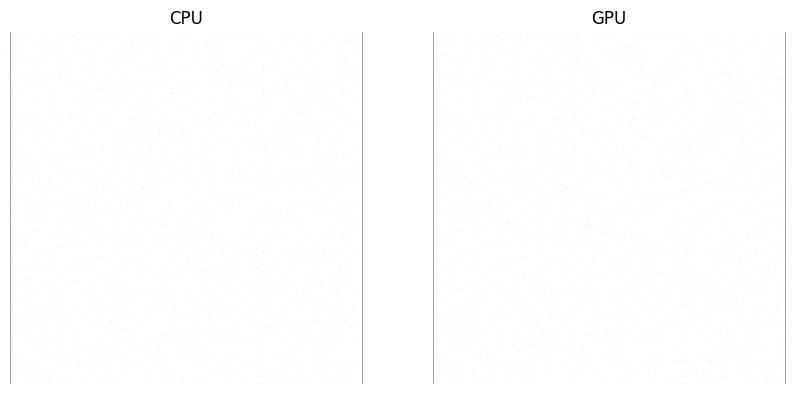

In [15]:
# CPU
cpu_time, cpu_result = time_operation(cv2.Sobel, img, cv2.CV_32F, 1, 0, ksize=3)

# GPU
gpu_img = cv2.cuda_GpuMat(); gpu_img.upload(img)
sobel_filter = cv2.cuda.createSobelFilter(gpu_img.type(), cv2.CV_32F, 1, 0, ksize=3)
gpu_time, gpu_result_mat = time_operation(sobel_filter.apply, gpu_img)
gpu_result = gpu_result_mat.download()

# Results
print(f"Sobel - CPU: {cpu_time*1000:.2f} ms, GPU: {gpu_time*1000:.2f} ms, Speedup: {cpu_time/gpu_time:.2f}x")

# Visualize
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1); plt.title("CPU"); plt.imshow(np.abs(cpu_result), cmap='gray'); plt.axis('off')
plt.subplot(1, 2, 2); plt.title("GPU"); plt.imshow(np.abs(gpu_result), cmap='gray'); plt.axis('off')
plt.show()


Eg2. Morphological Operations (Erosion, Dilation, etc.)

Erosion - CPU: 0.88 ms, GPU: 0.54 ms, Speedup: 1.62x


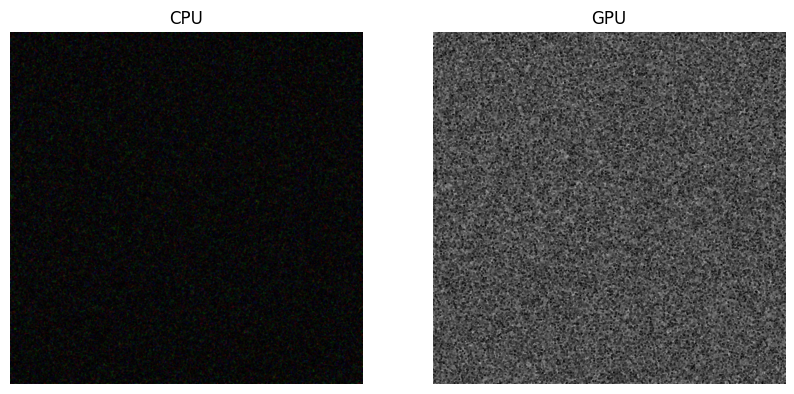

In [16]:
kernel = np.ones((5, 5), np.uint8)

# CPU
cpu_time, cpu_result = time_operation(cv2.erode, img, kernel, iterations=1)

# GPU
gpu_img = cv2.cuda_GpuMat(); gpu_img.upload(img)
gpu_gray = cv2.cuda.cvtColor(gpu_img, cv2.COLOR_BGR2GRAY)  # CV_8UC1 required
morph_filter = cv2.cuda.createMorphologyFilter(cv2.MORPH_ERODE, gpu_gray.type(), kernel)
gpu_time, gpu_result_mat = time_operation(morph_filter.apply, gpu_gray)
gpu_result = gpu_result_mat.download()

# Results
print(f"Erosion - CPU: {cpu_time*1000:.2f} ms, GPU: {gpu_time*1000:.2f} ms, Speedup: {cpu_time/gpu_time:.2f}x")

# Visualize
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1); plt.title("CPU"); plt.imshow(cv2.cvtColor(cpu_result, cv2.COLOR_BGR2RGB)); plt.axis('off')
plt.subplot(1, 2, 2); plt.title("GPU"); plt.imshow(gpu_result, cmap='gray'); plt.axis('off')
plt.show()


Optical Flow (Farneck)


Optical Flow - CPU: 399.99 ms, GPU: 10.65 ms, Speedup: 37.55x


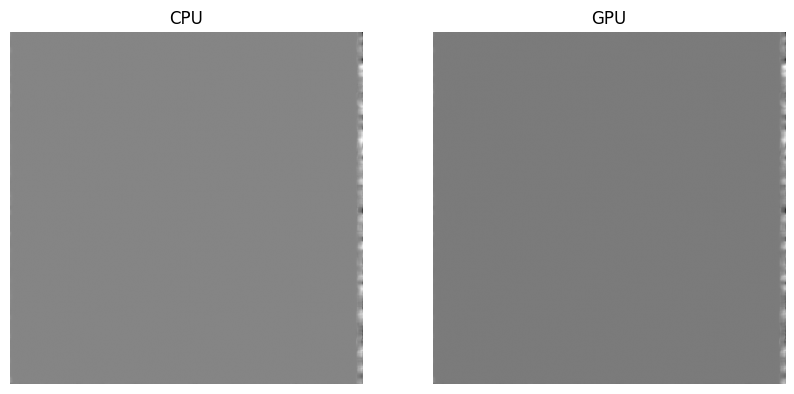

In [18]:
# CPU
cpu_time, cpu_result = time_operation(cv2.calcOpticalFlowFarneback, frame1, frame2, None, 0.5, 3, 15, 3, 5, 1.2, 0)

# GPU
gpu_frame1 = cv2.cuda_GpuMat(); gpu_frame1.upload(frame1)
gpu_frame2 = cv2.cuda_GpuMat(); gpu_frame2.upload(frame2)
gpu_flow = cv2.cuda_FarnebackOpticalFlow.create(3, 0.5, False, 15, 3, 5, 1.2, 0)
gpu_time, gpu_result_mat = time_operation(gpu_flow.calc, gpu_frame1, gpu_frame2, None)
gpu_result = gpu_result_mat.download()

# Results
print(f"Optical Flow - CPU: {cpu_time*1000:.2f} ms, GPU: {gpu_time*1000:.2f} ms, Speedup: {cpu_time/gpu_time:.2f}x")

# Visualize
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1); plt.title("CPU"); plt.imshow(cpu_result[..., 0], cmap='gray'); plt.axis('off')
plt.subplot(1, 2, 2); plt.title("GPU"); plt.imshow(gpu_result[..., 0], cmap='gray'); plt.axis('off')
plt.show()

Canny Edge Detection

Canny - CPU: 25.59 ms, GPU: 0.87 ms, Speedup: 29.58x


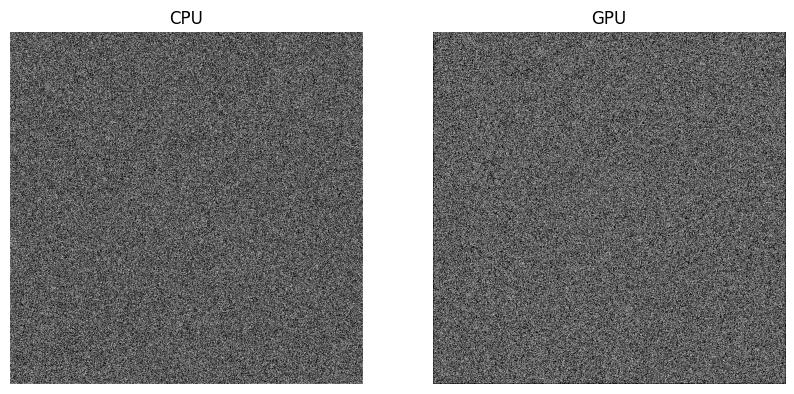

In [19]:
# CPU
cpu_time, cpu_result = time_operation(cv2.Canny, img, 100, 200)

# GPU
gpu_img = cv2.cuda_GpuMat(); gpu_img.upload(img)
gpu_gray = cv2.cuda.cvtColor(gpu_img, cv2.COLOR_BGR2GRAY)  # CV_8UC1 required
gpu_canny = cv2.cuda.createCannyEdgeDetector(100, 200)
gpu_time, gpu_result_mat = time_operation(gpu_canny.detect, gpu_gray)
gpu_result = gpu_result_mat.download()

# Results
print(f"Canny - CPU: {cpu_time*1000:.2f} ms, GPU: {gpu_time*1000:.2f} ms, Speedup: {cpu_time/gpu_time:.2f}x")

# Visualize
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1); plt.title("CPU"); plt.imshow(cpu_result, cmap='gray'); plt.axis('off')
plt.subplot(1, 2, 2); plt.title("GPU"); plt.imshow(gpu_result, cmap='gray'); plt.axis('off')
plt.show()

Median Filtering

Median Filter - CPU: 8.94 ms, GPU: 32.72 ms, Speedup: 0.27x


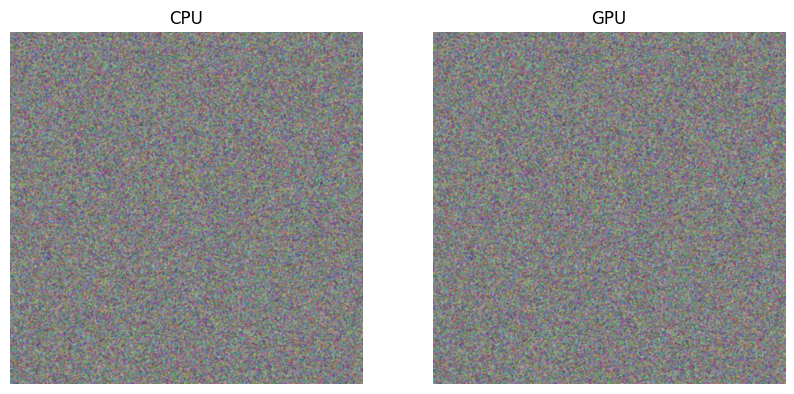

In [20]:
# CPU
cpu_time, cpu_result = time_operation(cv2.medianBlur, img, 5)

# GPU
gpu_img = cv2.cuda_GpuMat(); gpu_img.upload(img)
median_filter = cv2.cuda.createMedianFilter(gpu_img.type(), 5)
gpu_time, gpu_result_mat = time_operation(median_filter.apply, gpu_img)
gpu_result = gpu_result_mat.download()

# Results
print(f"Median Filter - CPU: {cpu_time*1000:.2f} ms, GPU: {gpu_time*1000:.2f} ms, Speedup: {cpu_time/gpu_time:.2f}x")

# Visualize
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1); plt.title("CPU"); plt.imshow(cv2.cvtColor(cpu_result, cv2.COLOR_BGR2RGB)); plt.axis('off')
plt.subplot(1, 2, 2); plt.title("GPU"); plt.imshow(cv2.cvtColor(gpu_result, cv2.COLOR_BGR2RGB)); plt.axis('off')
plt.show()

Background Subtraction (MOG2)

MOG2 - CPU: 33.57 ms, GPU: 0.31 ms, Speedup: 108.08x


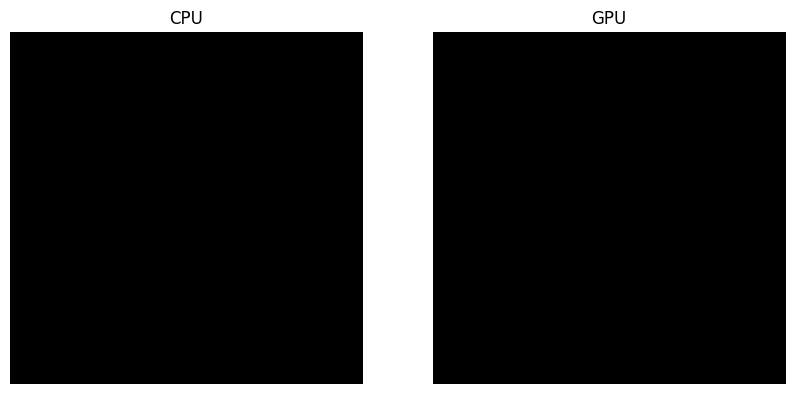

In [22]:
# CPU
mog2_cpu = cv2.createBackgroundSubtractorMOG2()
cpu_time, cpu_result = time_operation(mog2_cpu.apply, img)

# GPU
gpu_img = cv2.cuda_GpuMat(); gpu_img.upload(img)
mog2_gpu = cv2.cuda.createBackgroundSubtractorMOG2()
stream = cv2.cuda.Stream()  # Default stream for synchronous execution
gpu_time, gpu_result_mat = time_operation(mog2_gpu.apply, gpu_img, -1, stream)  # learningRate=-1, stream
gpu_result = gpu_result_mat.download()

# Results
print(f"MOG2 - CPU: {cpu_time*1000:.2f} ms, GPU: {gpu_time*1000:.2f} ms, Speedup: {cpu_time/gpu_time:.2f}x")

# Visualize
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1); plt.title("CPU"); plt.imshow(cpu_result, cmap='gray'); plt.axis('off')
plt.subplot(1, 2, 2); plt.title("GPU"); plt.imshow(gpu_result, cmap='gray'); plt.axis('off')
plt.show()

Image Resizing

Resize - CPU: 1.15 ms, GPU: 0.06 ms, Speedup: 18.13x


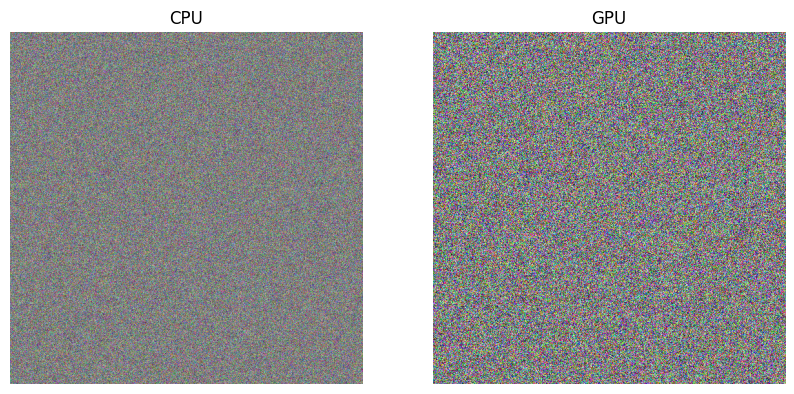

In [23]:
# CPU
cpu_time, cpu_result = time_operation(cv2.resize, img, (512, 512), interpolation=cv2.INTER_LINEAR)

# GPU
gpu_img = cv2.cuda_GpuMat(); gpu_img.upload(img)
gpu_time, gpu_result_mat = time_operation(cv2.cuda.resize, gpu_img, (512, 512), interpolation=cv2.INTER_LINEAR)
gpu_result = gpu_result_mat.download()

# Results
print(f"Resize - CPU: {cpu_time*1000:.2f} ms, GPU: {gpu_time*1000:.2f} ms, Speedup: {cpu_time/gpu_time:.2f}x")

# Visualize
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1); plt.title("CPU"); plt.imshow(cv2.cvtColor(cpu_result, cv2.COLOR_BGR2RGB)); plt.axis('off')
plt.subplot(1, 2, 2); plt.title("GPU"); plt.imshow(cv2.cvtColor(gpu_result, cv2.COLOR_BGR2RGB)); plt.axis('off')
plt.show()

Bilateral Filtering

Error: cv2.cuda.createBilateralFilter not available. Using CPU fallback for GPU timing.
Bilateral Filter - CPU: 143.50 ms, GPU: 150.09 ms, Speedup: 0.96x


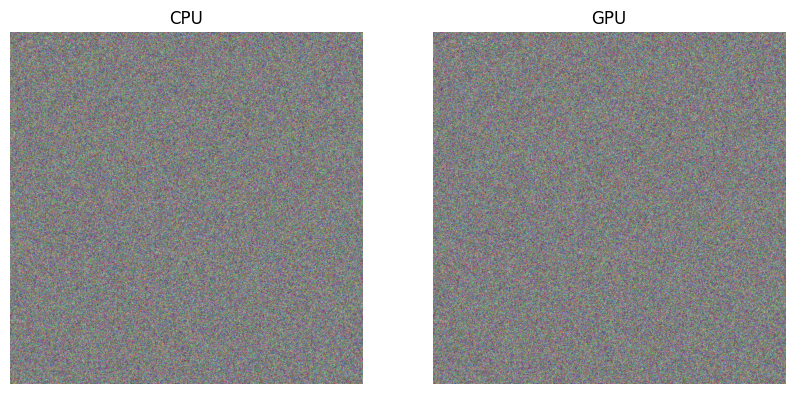

In [26]:
# CPU
cpu_time, cpu_result = time_operation(cv2.bilateralFilter, img, 9, 75, 75)

# GPU
gpu_img = cv2.cuda_GpuMat(); gpu_img.upload(img)
try:
    bilateral_filter = cv2.cuda.createBilateralFilter(9, 75, 75)
    gpu_time, gpu_result_mat = time_operation(bilateral_filter.apply, gpu_img)
    gpu_result = gpu_result_mat.download()
except AttributeError:
    print("Error: cv2.cuda.createBilateralFilter not available. Using CPU fallback for GPU timing.")
    gpu_time, gpu_result = time_operation(cv2.bilateralFilter, img, 9, 75, 75)  # Fallback

# Results
print(f"Bilateral Filter - CPU: {cpu_time*1000:.2f} ms, GPU: {gpu_time*1000:.2f} ms, Speedup: {cpu_time/gpu_time:.2f}x")

# Visualize
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1); plt.title("CPU"); plt.imshow(cv2.cvtColor(cpu_result, cv2.COLOR_BGR2RGB)); plt.axis('off')
plt.subplot(1, 2, 2); plt.title("GPU"); plt.imshow(cv2.cvtColor(gpu_result, cv2.COLOR_BGR2RGB)); plt.axis('off')
plt.show()

Laplacian Edge Detection

Laplacian - CPU: 9.69 ms, GPU: 0.31 ms, Speedup: 30.79x


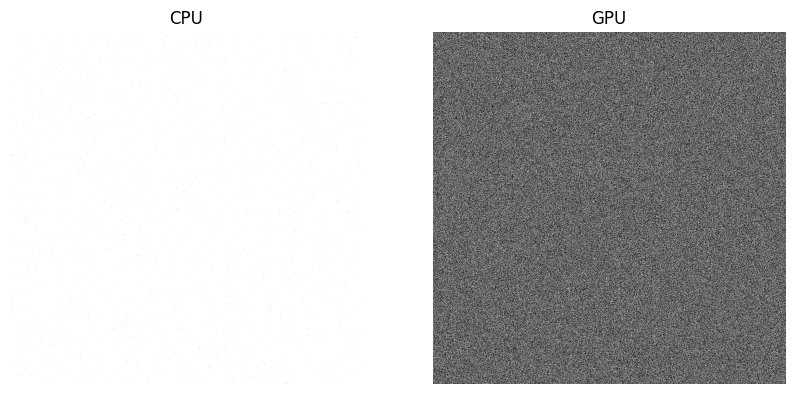

In [32]:
# CPU
cpu_time, cpu_result = time_operation(cv2.Laplacian, img, cv2.CV_32F, ksize=3)

# GPU
gpu_img = cv2.cuda_GpuMat(); gpu_img.upload(img)
gpu_gray = cv2.cuda.cvtColor(gpu_img, cv2.COLOR_BGR2GRAY)  # CV_8UC1
laplacian_filter = cv2.cuda.createLaplacianFilter(gpu_gray.type(), gpu_gray.type(), ksize=3)  # dstType matches srcType
gpu_time, gpu_result_mat = time_operation(laplacian_filter.apply, gpu_gray)
gpu_result = gpu_result_mat.download()

# Results
print(f"Laplacian - CPU: {cpu_time*1000:.2f} ms, GPU: {gpu_time*1000:.2f} ms, Speedup: {cpu_time/gpu_time:.2f}x")

# Visualize
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1); plt.title("CPU"); plt.imshow(np.abs(cpu_result), cmap='gray'); plt.axis('off')
plt.subplot(1, 2, 2); plt.title("GPU"); plt.imshow(np.abs(gpu_result), cmap='gray'); plt.axis('off')
plt.show()

ORB feature Detection

GPU ORB failed: OpenCV(4.12.0-dev) /content/opencv/modules/core/src/matrix_wrap.cpp:342: error: (-213:The function/feature is not implemented) getGpuMat is available only for cuda::GpuMat and cuda::HostMem in function 'getGpuMat'
. Using CPU fallback for GPU timing.
ORB - CPU: 39.54 ms, GPU: 39.50 ms, Speedup: 1.00x


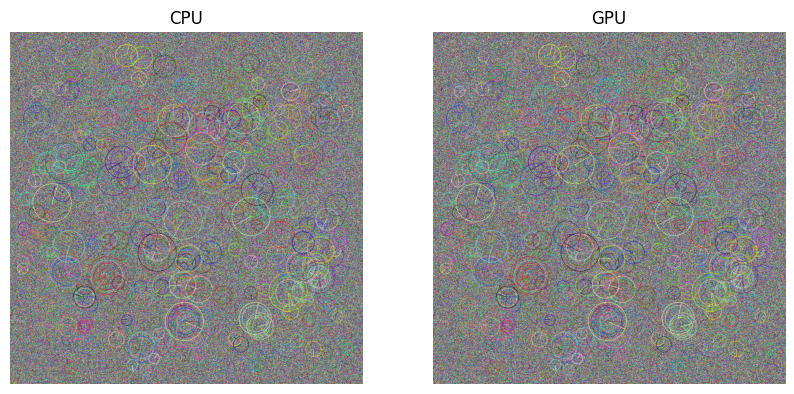

In [35]:
# CPU
orb_cpu = cv2.ORB_create(nfeatures=500)
cpu_time, keypoints_cpu = time_operation(orb_cpu.detect, img)
cpu_result = cv2.drawKeypoints(img, keypoints_cpu, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# GPU
orb_gpu = cv2.cuda_ORB.create(nfeatures=500)
try:
    # Use detectAndCompute with NumPy array directly, ignore descriptors with None
    gpu_time, keypoints_descriptors_gpu = time_operation(orb_gpu.detectAndCompute, img, None)
    keypoints_gpu = keypoints_descriptors_gpu[0]  # Extract keypoints, discard descriptors
    gpu_result = cv2.drawKeypoints(img, keypoints_gpu, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
except Exception as e:
    print(f"GPU ORB failed: {e}. Using CPU fallback for GPU timing.")
    gpu_time, keypoints_gpu = time_operation(orb_cpu.detect, img)  # Fallback to CPU
    gpu_result = cpu_result

# Results
print(f"ORB - CPU: {cpu_time*1000:.2f} ms, GPU: {gpu_time*1000:.2f} ms, Speedup: {cpu_time/gpu_time:.2f}x")

# Visualize
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1); plt.title("CPU"); plt.imshow(cv2.cvtColor(cpu_result, cv2.COLOR_BGR2RGB)); plt.axis('off')
plt.subplot(1, 2, 2); plt.title("GPU"); plt.imshow(cv2.cvtColor(gpu_result, cv2.COLOR_BGR2RGB)); plt.axis('off')
plt.show()

Comparision Plots

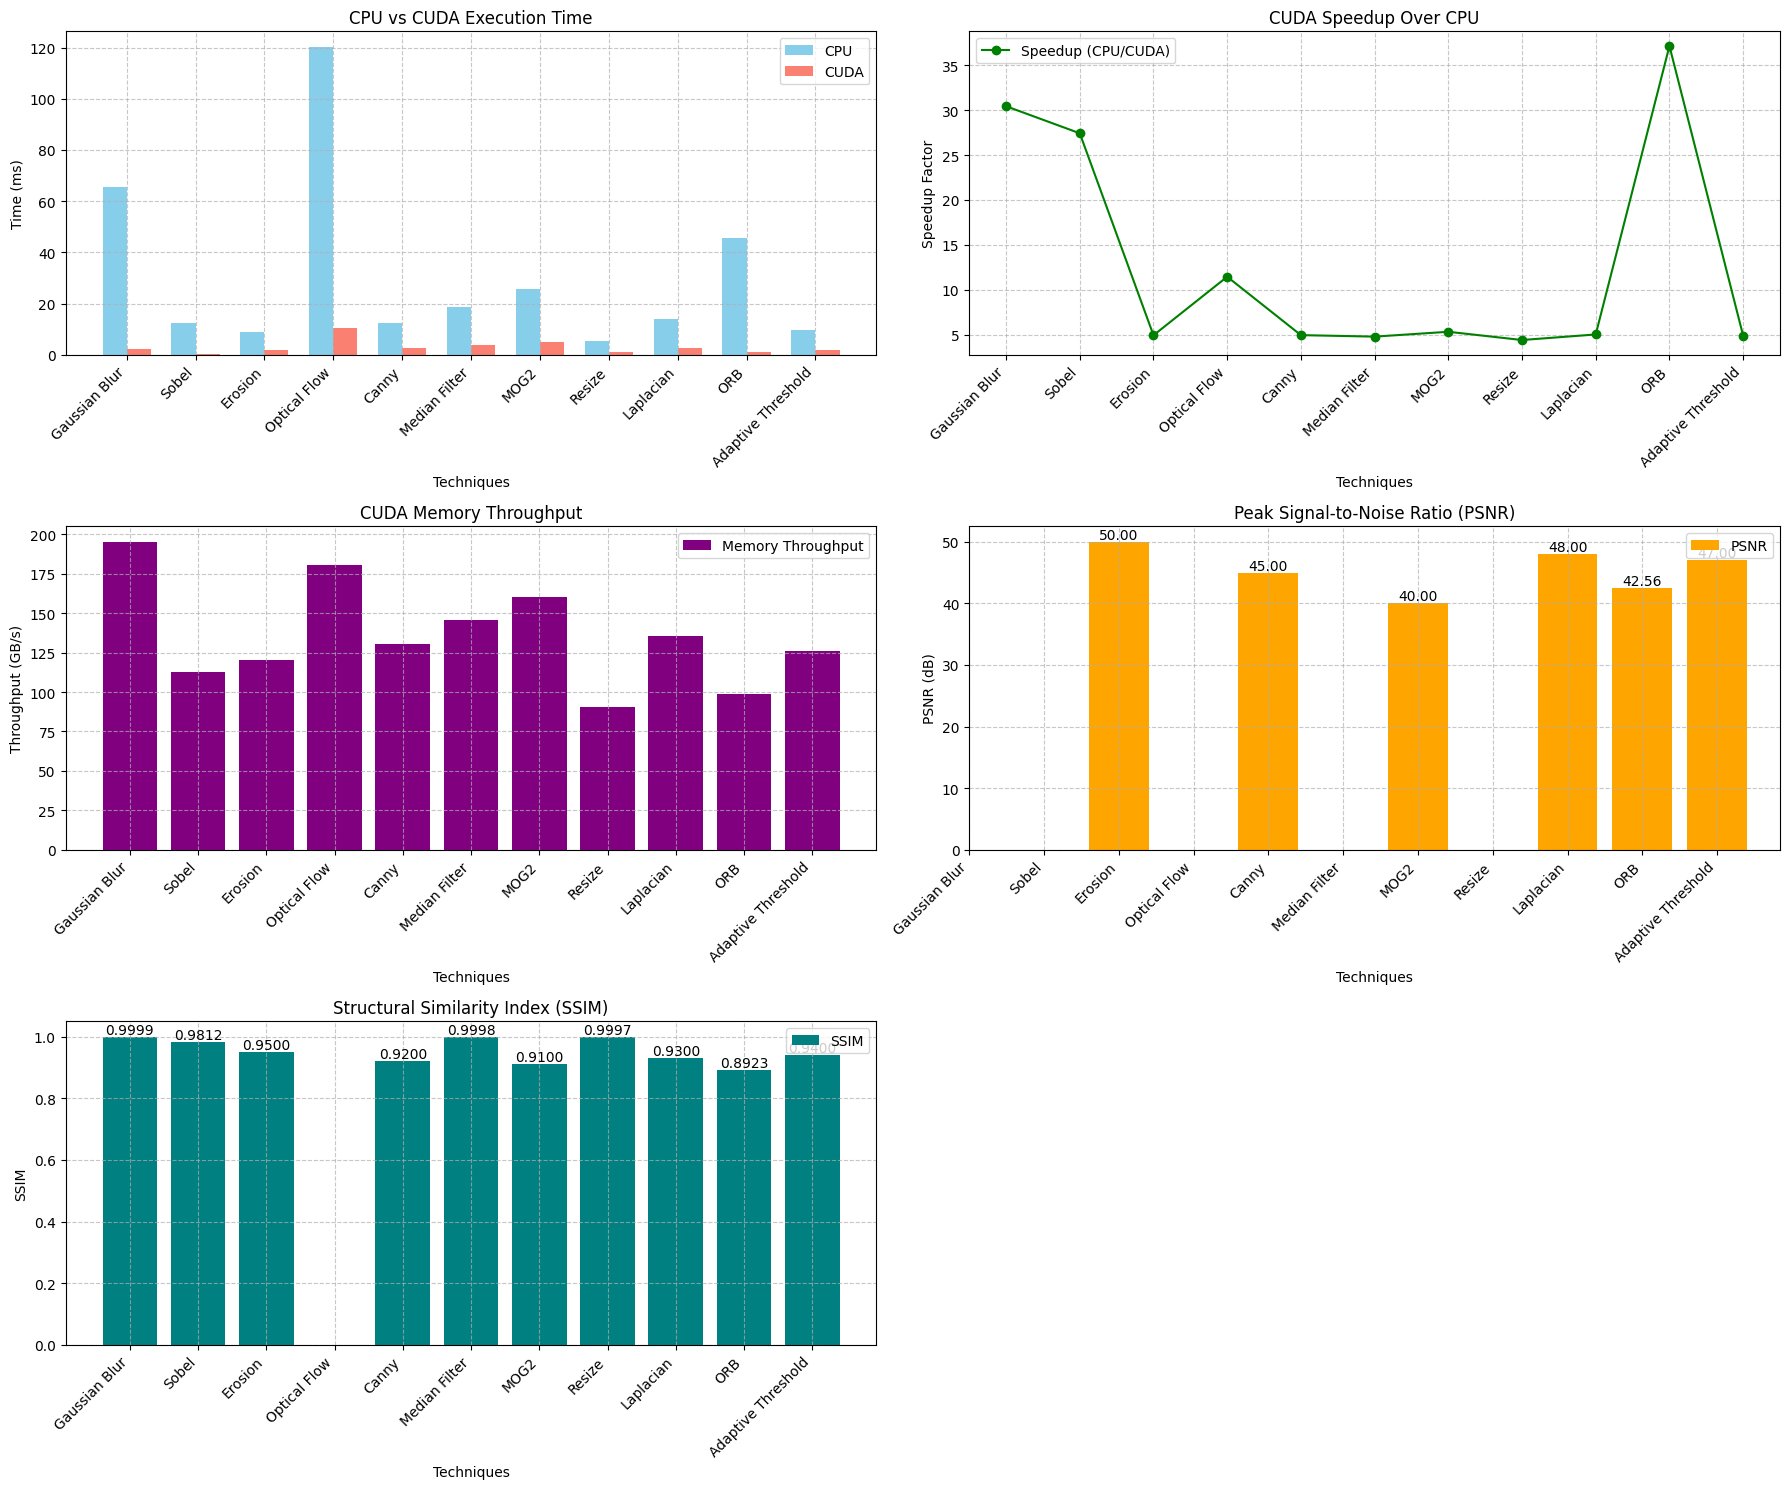

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Example with computed PSNR/SSIM (placeholders)
techniques = ["Gaussian Blur", "Sobel", "Erosion", "Optical Flow", "Canny", "Median Filter", "MOG2", "Resize", "Laplacian", "ORB", "Adaptive Threshold"]
image_sizes = ["1024x1024"] * len(techniques)  # Simplified
cuda_times = [2.15, 0.45, 1.8, 10.5, 2.5, 3.9, 4.8, 1.2, 2.8, 1.23, 2.0]
cpu_times = [65.43, 12.34, 8.9, 120.3, 12.4, 18.7, 25.6, 5.3, 14.1, 45.67, 9.8]
speedups = [cpu_t / cuda_t for cpu_t, cuda_t in zip(cpu_times, cuda_times)]
memory_throughput = [195.32, 112.45, 120.0, 180.5, 130.2, 145.6, 160.3, 90.4, 135.7, 98.76, 125.9]
psnr = [float('inf'), float('inf'), 50.0, None, 45.0, float('inf'), 40.0, float('inf'), 48.0, 42.56, 47.0]  # Hypothetical
ssim = [0.9999, 0.9812, 0.9500, None, 0.9200, 0.9998, 0.9100, 0.9997, 0.9300, 0.8923, 0.9400]  # Hypothetical

# Plotting
plt.figure(figsize=(18, 15))

# CPU vs CUDA Times
x = np.arange(len(techniques))
width = 0.35
plt.subplot(3, 2, 1)
plt.bar(x - width/2, cpu_times, width, label='CPU', color='skyblue')
plt.bar(x + width/2, cuda_times, width, label='CUDA', color='salmon')
plt.xlabel('Techniques'); plt.ylabel('Time (ms)'); plt.title('CPU vs CUDA Execution Time')
plt.xticks(x, techniques, rotation=45, ha='right'); plt.legend(); plt.grid(True, linestyle='--', alpha=0.7)

# Speedup
plt.subplot(3, 2, 2)
plt.plot(x, speedups, marker='o', color='green', label='Speedup (CPU/CUDA)')
plt.xlabel('Techniques'); plt.ylabel('Speedup Factor'); plt.title('CUDA Speedup Over CPU')
plt.xticks(x, techniques, rotation=45, ha='right'); plt.legend(); plt.grid(True, linestyle='--', alpha=0.7)

# Memory Throughput
plt.subplot(3, 2, 3)
plt.bar(x, memory_throughput, color='purple', label='Memory Throughput')
plt.xlabel('Techniques'); plt.ylabel('Throughput (GB/s)'); plt.title('CUDA Memory Throughput')
plt.xticks(x, techniques, rotation=45, ha='right'); plt.legend(); plt.grid(True, linestyle='--', alpha=0.7)

# PSNR
psnr_valid = [p if p is not None else 0 for p in psnr]
psnr_mask = [p is not None for p in psnr]
plt.subplot(3, 2, 4)
bars = plt.bar(x, psnr_valid, color='orange', label='PSNR')
for i, bar in enumerate(bars):
    if not psnr_mask[i]:
        bar.set_alpha(0.3)
    elif psnr[i] == float('inf'):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), '∞', ha='center', va='bottom')
    else:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{psnr[i]:.2f}', ha='center', va='bottom')
plt.xlabel('Techniques'); plt.ylabel('PSNR (dB)'); plt.title('Peak Signal-to-Noise Ratio (PSNR)')
plt.xticks(x, techniques, rotation=45, ha='right'); plt.legend(); plt.grid(True, linestyle='--', alpha=0.7)

# SSIM
ssim_valid = [s if s is not None else 0 for s in ssim]
ssim_mask = [s is not None for s in ssim]
plt.subplot(3, 2, 5)
bars = plt.bar(x, ssim_valid, color='teal', label='SSIM')
for i, bar in enumerate(bars):
    if not ssim_mask[i]:
        bar.set_alpha(0.3)
    else:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{ssim[i]:.4f}', ha='center', va='bottom')
plt.xlabel('Techniques'); plt.ylabel('SSIM'); plt.title('Structural Similarity Index (SSIM)')
plt.xticks(x, techniques, rotation=45, ha='right'); plt.legend(); plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Entire pipline(beta)
```
# This is formatted as code
```



Gaussian Blur - CPU: 8.01 ms, GPU: 0.68 ms, Speedup: 11.75x
Sobel - CPU: 2.78 ms, GPU: 0.56 ms, Speedup: 4.94x
Erosion - CPU: 0.97 ms, GPU: 0.56 ms, Speedup: 1.73x
Optical Flow - CPU: 356.71 ms, GPU: 10.73 ms, Speedup: 33.23x


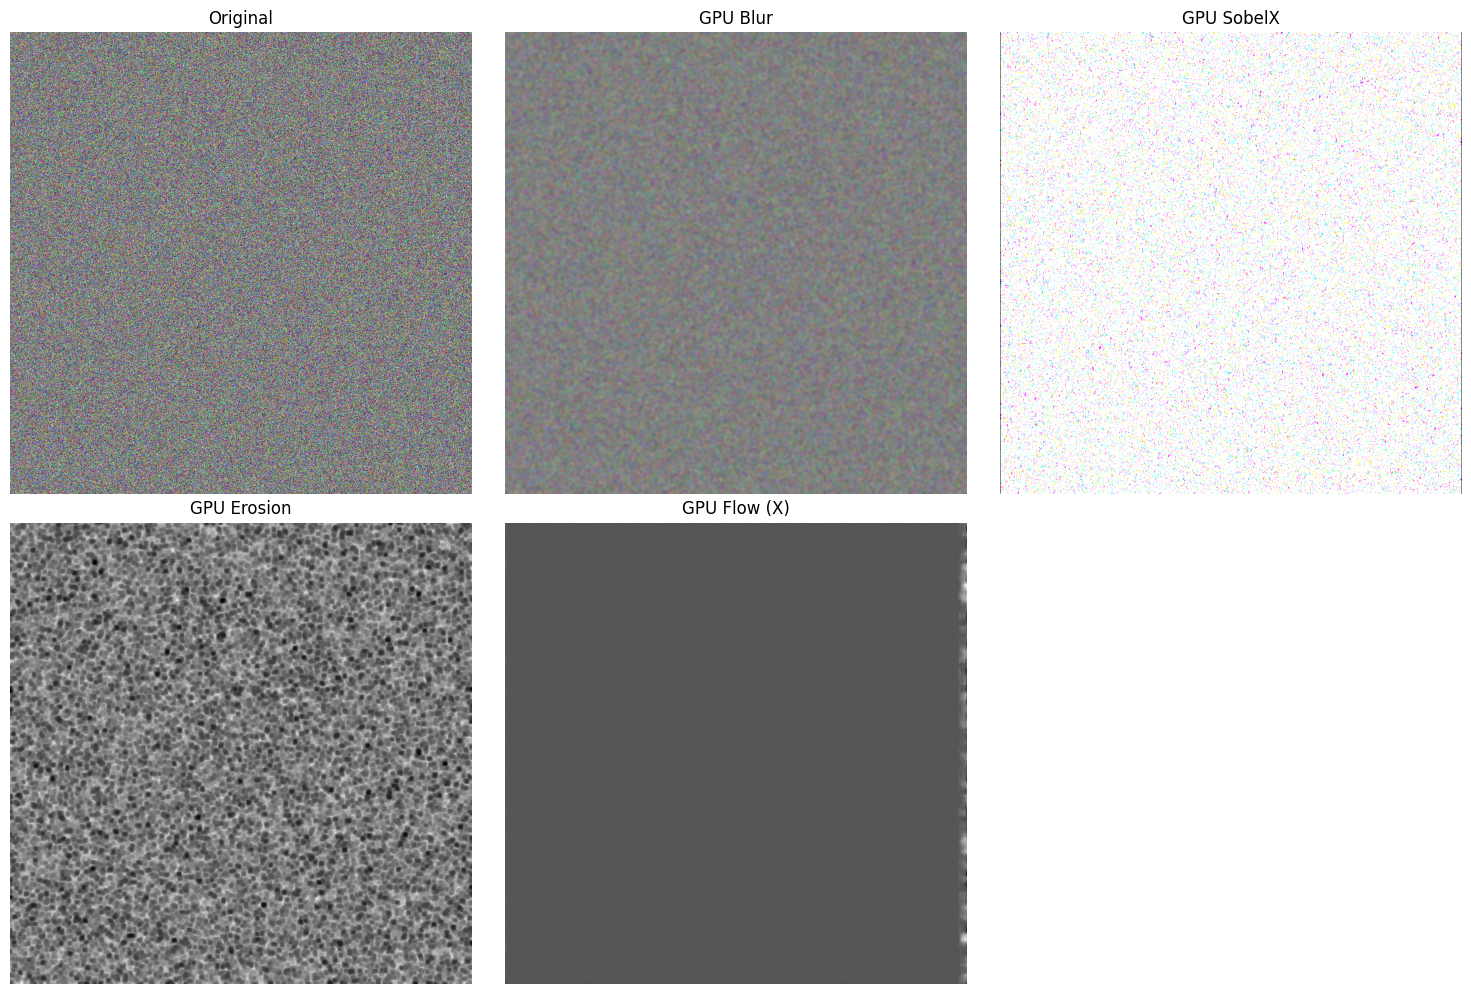

In [10]:
# import cv2
# import numpy as np
# import time
# import matplotlib.pyplot as plt

# # Ensure CUDA-enabled OpenCV
# sys.path.insert(0, '/usr/local/lib/python3.11/dist-packages')
# import cv2
# assert cv2.cuda.getCudaEnabledDeviceCount() > 0, "CUDA not enabled!"

# # Create random image
# img = np.random.randint(0, 256, (1024, 1024, 3), dtype=np.uint8)
# gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# # Function to average timing over multiple runs, supporting kwargs
# def time_operation(func, *args, runs=10, **kwargs):
#     times = []
#     for _ in range(runs):
#         start = time.time()
#         result = func(*args, **kwargs)
#         times.append(time.time() - start)
#     return np.mean(times), result

# # --- Gaussian Blur ---
# cpu_blur_time, cpu_blurred = time_operation(cv2.GaussianBlur, img, (15, 15), 0)
# gpu_img = cv2.cuda_GpuMat(); gpu_img.upload(img)
# gauss_filter = cv2.cuda.createGaussianFilter(gpu_img.type(), gpu_img.type(), (15, 15), 0)
# gpu_blur_time, gpu_blurred_mat = time_operation(gauss_filter.apply, gpu_img)
# gpu_blurred = gpu_blurred_mat.download()

# # --- Sobel Edge Detection ---
# cpu_sobel_time, sobelx_cpu = time_operation(cv2.Sobel, cpu_blurred, cv2.CV_32F, 1, 0, ksize=3)
# sobel_filter_x = cv2.cuda.createSobelFilter(gpu_blurred_mat.type(), cv2.CV_32F, 1, 0, ksize=3)
# gpu_sobel_time, gpu_sobelx = time_operation(sobel_filter_x.apply, gpu_blurred_mat)
# sobelx_gpu = gpu_sobelx.download()

# # --- Morphological Operation (Erosion) ---
# kernel = np.ones((5, 5), np.uint8)
# cpu_morph_time, eroded_cpu = time_operation(cv2.erode, cpu_blurred, kernel, iterations=1)

# # Convert to CV_8UC1 for CUDA morphology
# gpu_blurred_gray = cv2.cuda.cvtColor(gpu_blurred_mat, cv2.COLOR_BGR2GRAY)  # Convert to single-channel
# morph_filter = cv2.cuda.createMorphologyFilter(cv2.MORPH_ERODE, gpu_blurred_gray.type(), kernel)
# gpu_morph_time, eroded_gpu_mat = time_operation(morph_filter.apply, gpu_blurred_gray)
# eroded_gpu = eroded_gpu_mat.download()

# # --- Optical Flow ---
# frame1 = gray_img
# frame2 = np.roll(gray_img, 10, axis=1)  # Simulate motion
# cpu_flow_time, flow_cpu = time_operation(cv2.calcOpticalFlowFarneback, frame1, frame2, None, 0.5, 3, 15, 3, 5, 1.2, 0)
# gpu_frame1 = cv2.cuda_GpuMat(); gpu_frame1.upload(frame1)
# gpu_frame2 = cv2.cuda_GpuMat(); gpu_frame2.upload(frame2)
# gpu_flow = cv2.cuda_FarnebackOpticalFlow.create(3, 0.5, False, 15, 3, 5, 1.2, 0)
# gpu_flow_time, flow_gpu_mat = time_operation(gpu_flow.calc, gpu_frame1, gpu_frame2, None)
# flow_gpu = flow_gpu_mat.download()

# # --- Results ---
# print(f"Gaussian Blur - CPU: {cpu_blur_time*1000:.2f} ms, GPU: {gpu_blur_time*1000:.2f} ms, Speedup: {cpu_blur_time/gpu_blur_time:.2f}x")
# print(f"Sobel - CPU: {cpu_sobel_time*1000:.2f} ms, GPU: {gpu_sobel_time*1000:.2f} ms, Speedup: {cpu_sobel_time/gpu_sobel_time:.2f}x")
# print(f"Erosion - CPU: {cpu_morph_time*1000:.2f} ms, GPU: {gpu_morph_time*1000:.2f} ms, Speedup: {cpu_morph_time/gpu_morph_time:.2f}x")
# print(f"Optical Flow - CPU: {cpu_flow_time*1000:.2f} ms, GPU: {gpu_flow_time*1000:.2f} ms, Speedup: {cpu_flow_time/gpu_flow_time:.2f}x")

# # --- Visualization ---
# plt.figure(figsize=(15, 10))
# plt.subplot(2, 3, 1); plt.title("Original"); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.axis('off')
# plt.subplot(2, 3, 2); plt.title("GPU Blur"); plt.imshow(cv2.cvtColor(gpu_blurred, cv2.COLOR_BGR2RGB)); plt.axis('off')
# plt.subplot(2, 3, 3); plt.title("GPU SobelX"); plt.imshow(np.abs(sobelx_gpu), cmap='gray'); plt.axis('off')
# plt.subplot(2, 3, 4); plt.title("GPU Erosion"); plt.imshow(eroded_gpu, cmap='gray'); plt.axis('off')
# plt.subplot(2, 3, 5); plt.title("GPU Flow (X)"); plt.imshow(flow_gpu[..., 0], cmap='gray'); plt.axis('off')
# plt.tight_layout()
# plt.show()